# Using Python tools for a analysis of COVID-19 data

# ARIMA method to forecast

#### Source: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

from sklearn.preprocessing import MinMaxScaler

In [2]:
mpl.rcParams['font.size'] = 15.0

In [3]:
pd.set_option("display.precision", 5)
pd.set_option('display.max_rows', 15)

### <span style="color:red">Analysis of the last N days</span>

In [4]:
Ndays = '180days'

### <span style="color:red">Day range for matplotlib</span>

In [5]:
Ninterval = 10

### <span style="color:red">Dataset source</span>

In [6]:
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'

In [7]:
# filename = '/home/davi/Documents/Python/Covid-19-Data/owid-covid-data.csv'

In [8]:
df = pd.read_csv(url)
# df = pd.read_csv(filename)
df['date'] = pd.to_datetime(df['date'])
df['location'] = df['location'].replace(['United States'],'United_States')
df['location'] = df['location'].replace(['United Kingdom'],'United_Kingdom')

In [9]:
df = df.loc[:,['date', 'location', 'total_cases', 'total_deaths', 'new_cases', 'new_deaths']]
df = df[df['date'] > pd.to_datetime("today") - pd.to_timedelta(Ndays)]
df = df.sort_values(by=['date'], ascending=True)
df

,date,location,total_cases,total_deaths,new_cases,new_deaths
3843,2020-02-27,Bahrain,33.0,0.0,10.0,0.0
31432,2020-02-27,Singapore,93.0,0.0,2.0,0.0
17044,2020-02-27,Ireland,0.0,0.0,0.0,0.0
22558,2020-02-27,Morocco,NaN,NaN,NaN,NaN
2792,2020-02-27,Belgium,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
16178,2020-08-24,Haiti,8082.0,196.0,32.0,0.0
16020,2020-08-24,Croatia,8175.0,171.0,275.0,1.0
15782,2020-08-24,Honduras,54511.0,1654.0,528.0,11.0
36783,2020-08-24,United_States,5702611.0,176806.0,34506.0,444.0


# Number of cases and deaths in World

In [10]:
dfWorld = df[df['location'] == 'World']
dfWorld = dfWorld.sort_values(by='date', ascending=True)
dfWorld = dfWorld.loc[:,['date', 'total_cases', 'total_deaths', 'new_cases', 'new_deaths']]
dfWorld.reset_index(drop=True, inplace=True)
dfWorld

,date,total_cases,total_deaths,new_cases,new_deaths
0,2020-02-27,82111.0,2800.0,1114.0,38.0
1,2020-02-28,83381.0,2857.0,1270.0,57.0
2,2020-02-29,85237.0,2921.0,1856.0,64.0
3,2020-03-01,87061.0,2979.0,1824.0,58.0
4,2020-03-02,89149.0,3046.0,2088.0,67.0
...,...,...,...,...,...
175,2020-08-20,22440556.0,787802.0,280994.0,6539.0
176,2020-08-21,22716727.0,794146.0,276171.0,6344.0
177,2020-08-22,22970240.0,800060.0,253513.0,5914.0
178,2020-08-23,23236330.0,805690.0,266090.0,5630.0


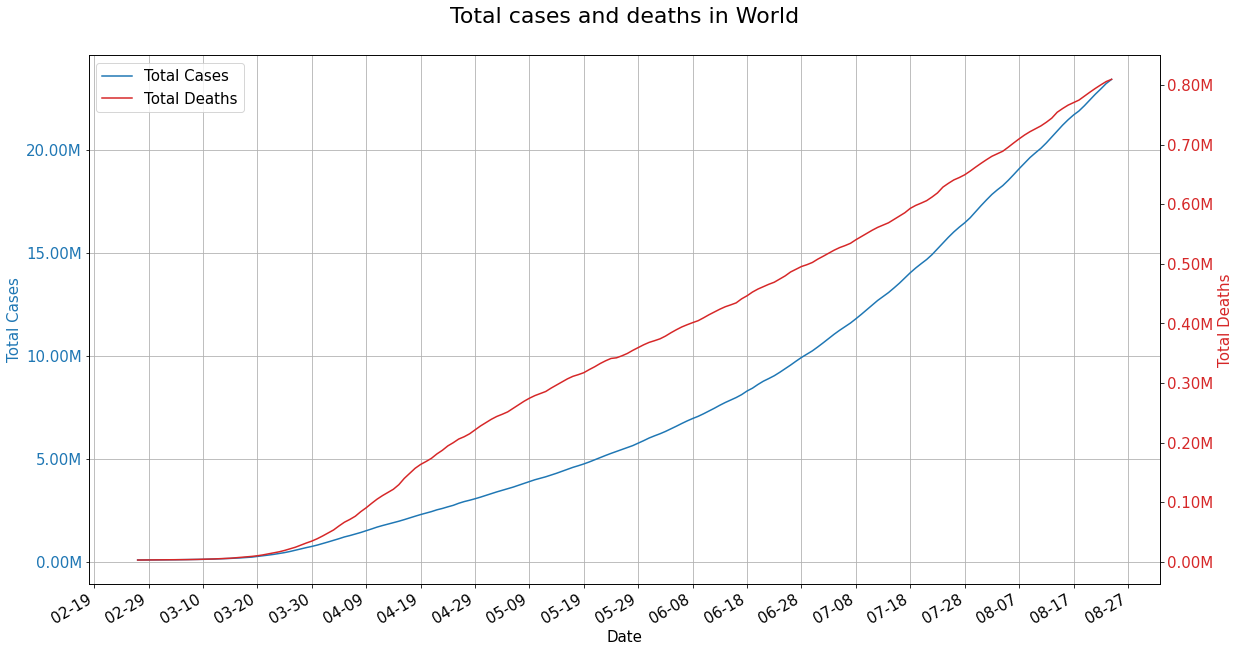

In [11]:
fig, ax1 = plt.subplots(figsize=(19.20,10.80))

color = 'tab:blue'
ax1.plot(dfWorld.date, dfWorld.total_cases, color=color, label='Total Cases')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Cases', color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Total cases and deaths in World', fontsize=22, y=1.05)
plt.grid()
ax2 = ax1.twinx()

color = 'tab:red'
ax2.plot(dfWorld.date, dfWorld.total_deaths, color=color, label = 'Total Deaths')
ax2.set_xlabel('Date')
ax2.set_ylabel('Total Deaths', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.2f}'.format(y/1000000) + 'M'))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.2f}'.format(y/1000000) + 'M'))
plt.gcf().autofmt_xdate()

fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)

plt.show()

### Forecast to total cases of COVID-19 in World for the next 60 days

In [12]:
y = dfWorld.loc[:,['date','total_cases']]
y = y.set_index('date')

In [13]:
p = d = q = range(0, 2)

In [14]:
pdq = list(itertools.product(p, d, q))

In [15]:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [16]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            print('FAIL')
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:6289.726487559476
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:116288.42234728824
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:5294.938513161669
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:4830.156128902943
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:4834.925149766119
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:4711.454168429608
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:4272.851936326437
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:4404.804523347206
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6125.258833092437
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:123962.906205386
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:5142.871702923477
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:4746.059160958957
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:5741.726186582357
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:6015.683998316059
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:4796.539356745193
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:4736.991051664894
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:4764.11261738889
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:4355.808727983878
ARIMA(0, 1,

#### A lower AIC value indicates a better fit

In [17]:
mod = sm.tsa.statespace.SARIMAX(y,
                               order=(1,1,1),
                               seasonal_order=(1,1,1,12),
                               enforce_stationarity=False,
                               enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9563      0.034     28.257      0.000       0.890       1.023
ma.L1          0.1898      0.103      1.847      0.065      -0.012       0.391
ar.S.L12      -0.2567      0.127     -2.013      0.044      -0.507      -0.007
ma.S.L12      -0.7282      0.087     -8.405      0.000      -0.898      -0.558
sigma2      5.243e+08   6.38e-11   8.22e+18      0.000    5.24e+08    5.24e+08


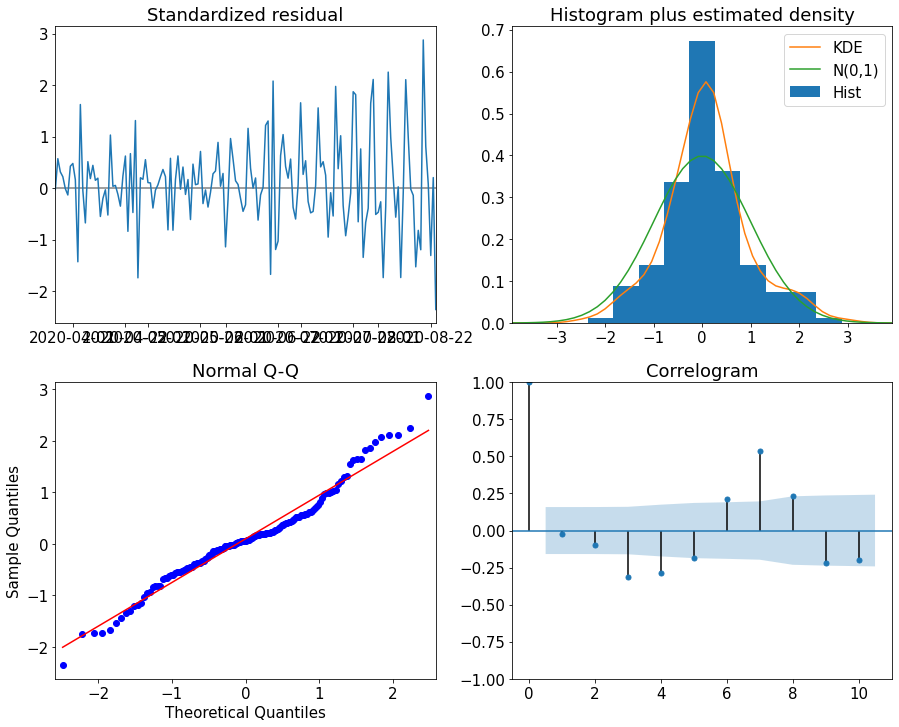

In [18]:
results.plot_diagnostics(figsize=(15,12))
plt.show()

In [19]:
pred = results.get_prediction(start=pd.to_datetime('2020-07-15'), dynamic=False)
pred_ci = pred.conf_int()

In [20]:
y_forecasted = pred.predicted_mean
y_truth = y['2020-07-15':]

In [21]:
stepsFuture = 60

In [22]:
pred_uc = results.get_forecast(steps=stepsFuture)
pred_ci = pred_uc.conf_int()

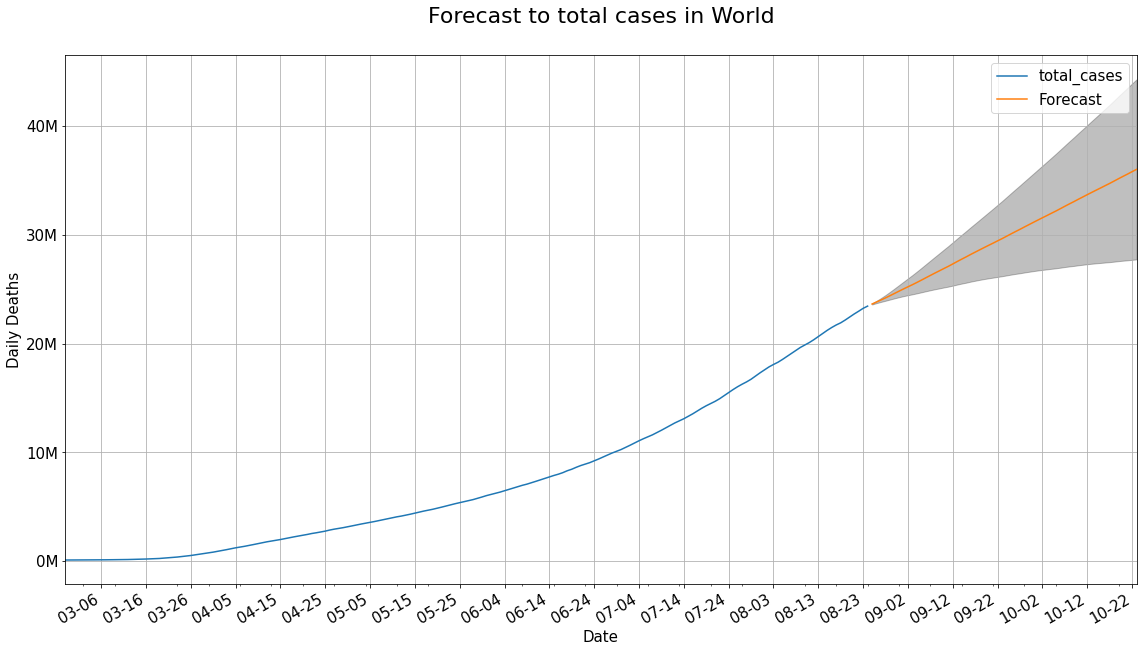

In [23]:
ax = y.plot(label='observed', figsize=(19.20, 10.80))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)


plt.title('Forecast to total cases in World', fontsize=22, y=1.05)

ax.tick_params(axis='y')
plt.ticklabel_format(style='plain', axis='y')

ax.set_xlabel('Date')
ax.set_ylabel('Daily Deaths')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gcf().autofmt_xdate()

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y/1000000) + 'M'))

plt.grid()
plt.legend()
plt.show()

### Forecast to total deaths of COVID-19 in World for the next 60 days

In [24]:
y = dfWorld.loc[:,['date','total_deaths']]
y = y.set_index('date')
y

,total_deaths
date,
2020-02-27,2800.0
2020-02-28,2857.0
2020-02-29,2921.0
2020-03-01,2979.0
2020-03-02,3046.0
...,...
2020-08-20,787802.0
2020-08-21,794146.0
2020-08-22,800060.0


In [25]:
p = d = q = range(0, 2)

In [26]:
pdq = list(itertools.product(p, d, q))

In [27]:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [28]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            print('FAIL')
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:5154.3631270999595
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:4714.357113336579
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:4147.029112434755
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3759.443548190872
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3947.1982836223006
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3824.8971784175355
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3458.5572852408013
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3425.4511600687383
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:4996.70826130007
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:4631.590311417063
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:4002.1417052376114
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3928.056716966926
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:4676.6869506989415
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:4622.952383099034
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:3726.7163066164712
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3680.276637287807
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:3539.3457928970447
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:3150.342995880344
AR

In [29]:
mod = sm.tsa.statespace.SARIMAX(y,
                               order=(1,1,1),
                               seasonal_order=(1,1,1,12),
                               enforce_stationarity=False,
                               enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9024      0.045     20.108      0.000       0.814       0.990
ma.L1         -0.0746      0.115     -0.650      0.516      -0.299       0.150
ar.S.L12      -0.0966      0.084     -1.155      0.248      -0.260       0.067
ma.S.L12      -0.9985      0.108     -9.230      0.000      -1.211      -0.786
sigma2      1.452e+06   7.52e-08   1.93e+13      0.000    1.45e+06    1.45e+06


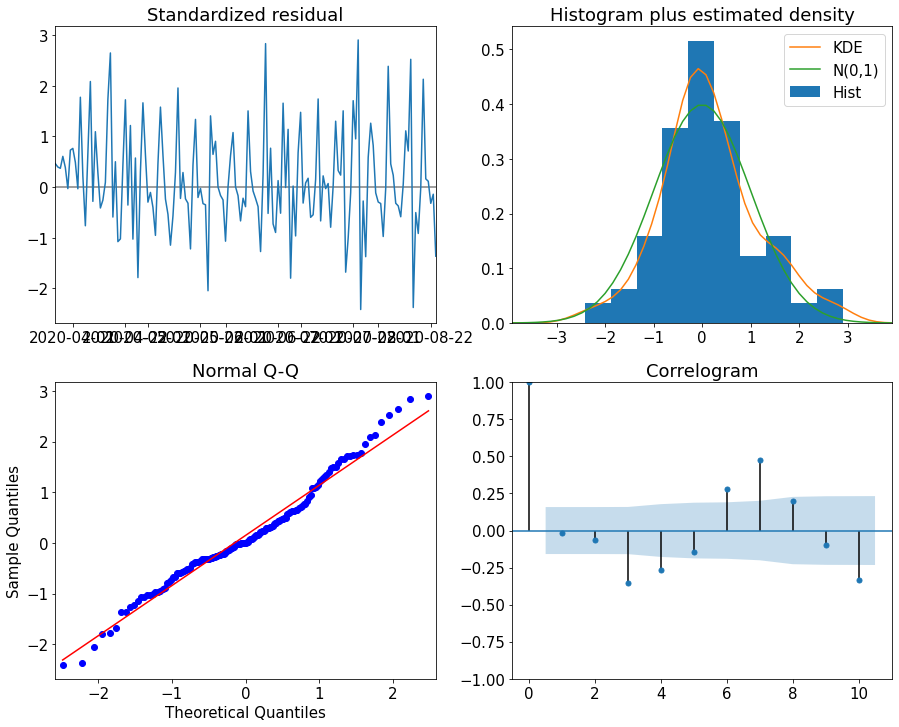

In [30]:
results.plot_diagnostics(figsize=(15,12))
plt.show()

In [31]:
pred = results.get_prediction(start=pd.to_datetime('2020-07-15'), dynamic=False)
pred_ci = pred.conf_int()

In [32]:
y_forecasted = pred.predicted_mean
y_truth = y['2020-07-15':]

In [33]:
stepsFuture = 60

In [34]:
pred_uc = results.get_forecast(steps=stepsFuture)
pred_ci = pred_uc.conf_int()

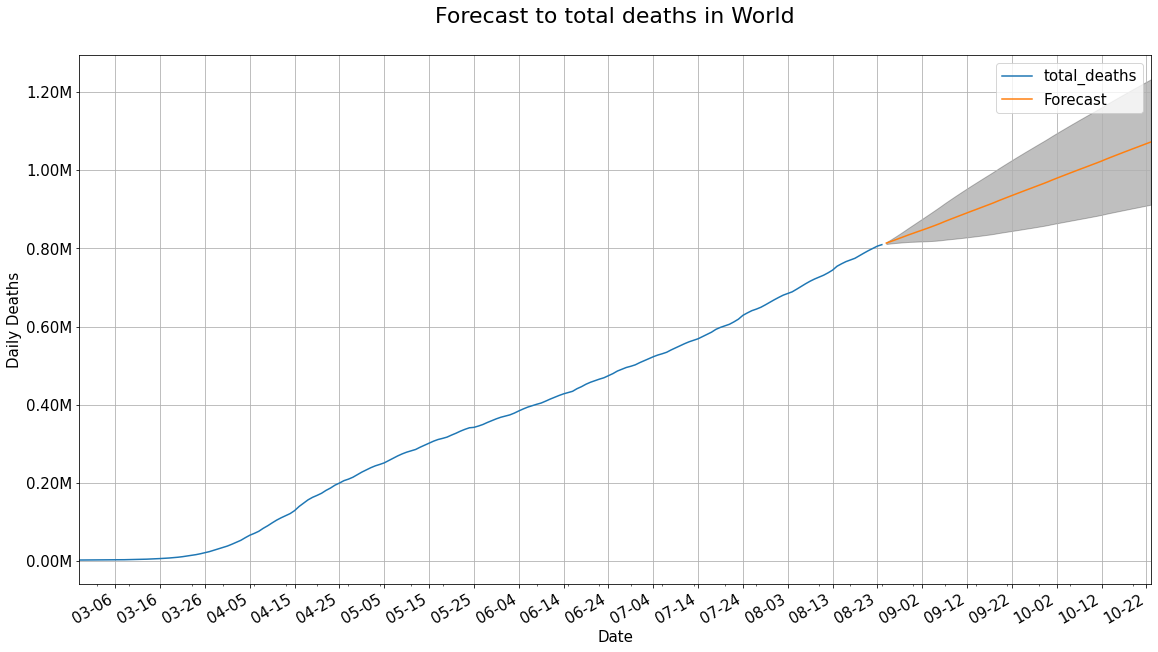

In [35]:
ax = y.plot(label='observed', figsize=(19.20, 10.80))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

plt.title('Forecast to total deaths in World', fontsize=22, y=1.05)

ax.tick_params(axis='y')
plt.ticklabel_format(style='plain', axis='y')

ax.set_xlabel('Date')
ax.set_ylabel('Daily Deaths')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gcf().autofmt_xdate()

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.2f}'.format(y/1000000) + 'M'))

plt.grid()
plt.legend()
plt.show()

###  Daily deaths [WORLD]

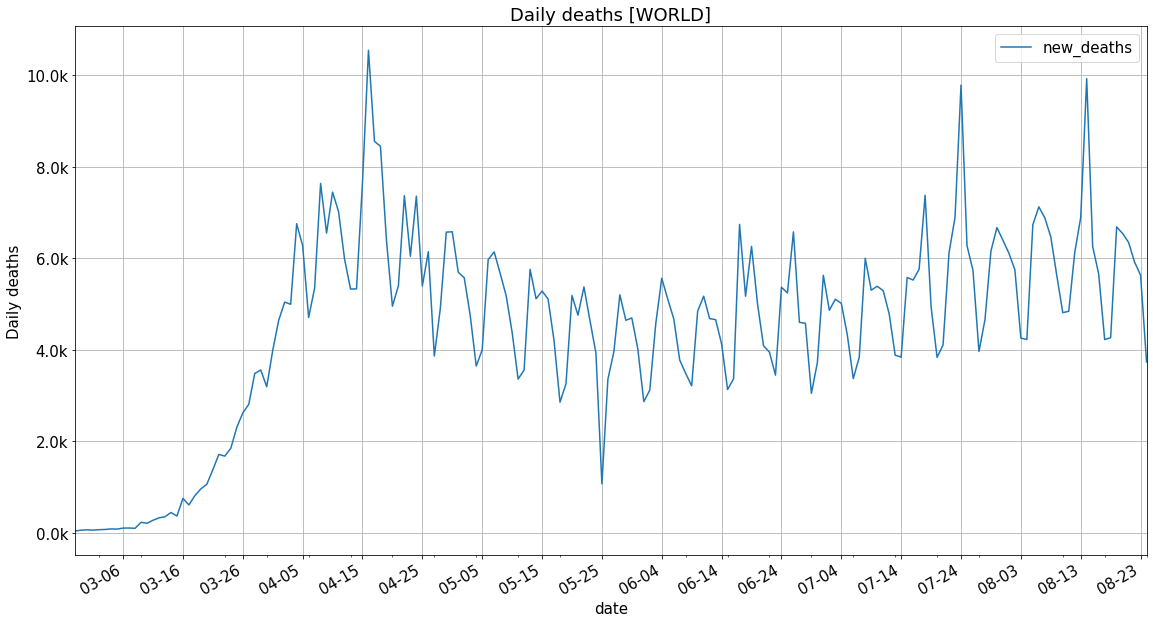

In [36]:
dfWorld.plot(x='date', y='new_deaths', figsize=(19.20,10.80))

plt.ylabel('Daily deaths')
plt.title('Daily deaths [WORLD]')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
plt.gcf().autofmt_xdate()

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.1f}'.format(y/1000) + 'k'))

plt.grid()
plt.show()

### Daily cases [WORLD]

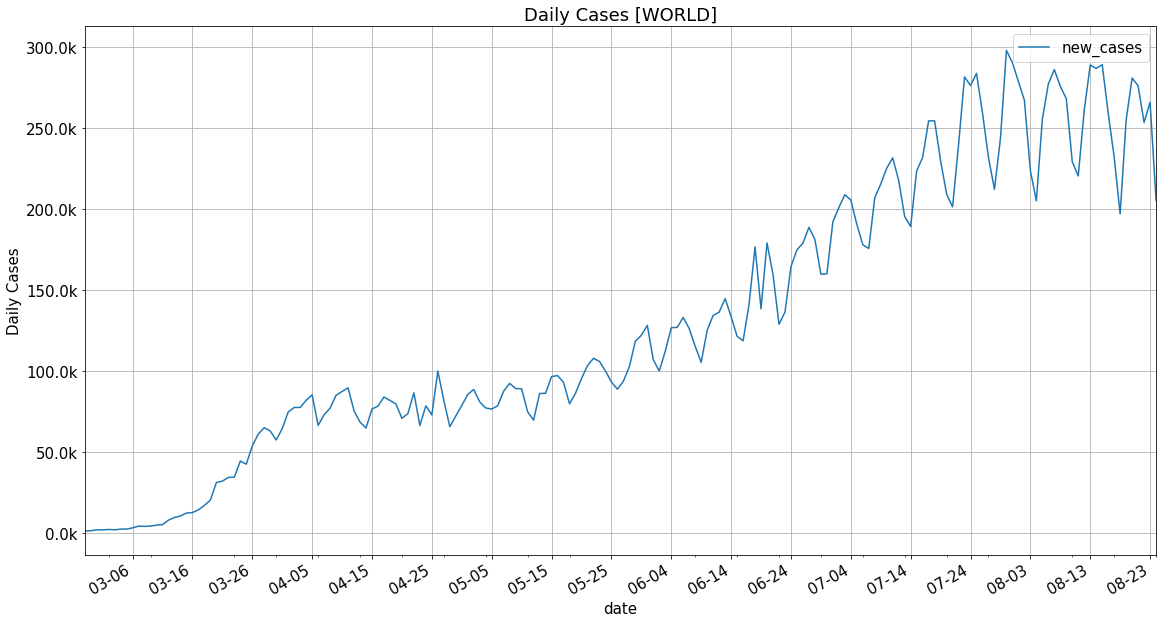

In [37]:
dfWorld.plot(x='date', y='new_cases', figsize=(19.20,10.80))

plt.ylabel('Daily Cases')
plt.title('Daily Cases [WORLD]')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
plt.gcf().autofmt_xdate()

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.1f}'.format(y/1000) + 'k'))

plt.grid()
plt.show()

In [38]:
dfFilter = df.loc[:,['date', 'location', 'total_cases', 'total_deaths']]
dfFilter = dfFilter[
        (df['location'] != 'World') &
        (df['location'] != 'International')
]

In [39]:
dfToday = dfFilter[dfFilter['date'] == dfFilter['date'].max()]

In [40]:
sumCases = dfToday.groupby(['location']).sum()
sumCases.reset_index(level=0, inplace=True)
sumCases.loc[sumCases['total_cases'] <= 500000, ['location']] = 'Other_Countries'

#### <span style="color:green">Countries with less than 500k cases are grouped under "Other_Countries"</span>

In [41]:
sumCases = sumCases.groupby(['location']).sum()
sumCases = sumCases.sort_values(by=['total_cases'], ascending=False)
sumCases

,total_cases,total_deaths
location,,
Other_Countries,7377930.0,296584.0
United_States,5702611.0,176806.0
Brazil,3605783.0,114744.0
India,3106348.0,57542.0
Russia,956749.0,16383.0
South Africa,609773.0,13059.0
Peru,594326.0,27663.0
Mexico,560164.0,60480.0
Colombia,541147.0,17316.0


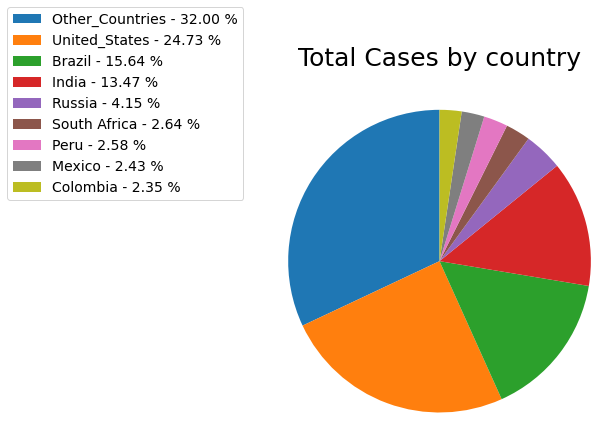

In [42]:
x = sumCases.index
y = sumCases.total_cases

porcent = 100.*y/y.sum()
fig = plt.figure(figsize=(10.20,5.80))
patches, texts = plt.pie(y, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='center right', bbox_to_anchor=(-0.1, 1.), fontsize=14)
plt.title('Total Cases by country', fontsize=25, y=1.1)
plt.show()

#### USA has 25% of all cases of COVID-19 in the world

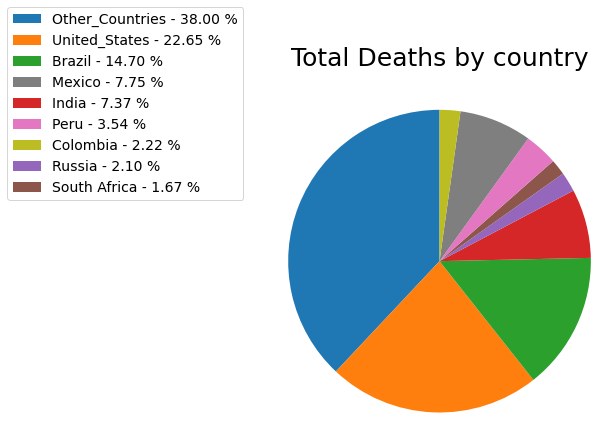

In [43]:
x = sumCases.index
y = sumCases.total_deaths

porcent = 100.*y/y.sum()
fig = plt.figure(figsize=(10.20,5.80))
patches, texts = plt.pie(y, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='center right', bbox_to_anchor=(-0.1, 1.), fontsize=14)
plt.title('Total Deaths by country', fontsize=25, y=1.1)
plt.show()

### USA has 22.65% of all deaths of COVID-19 in the world

##  COVID-19 cases and deaths in the most affected countries

#### <span style="color:red">Selecting Countries by the following conditions: 50k total cases and 35k deaths</span> 

In [44]:
numberCases = 50000
numberDeaths = 35000

In [45]:
mainCountries = df[
        (df['total_cases'] >= numberCases) & 
        (df['total_deaths'] >= numberDeaths) &
        (df['location'] != 'World') &
        (df['location'] != 'International')
]
mainCountries = mainCountries.sort_values(by=['total_cases'], ascending=False)
mainCountries = mainCountries.dropna()
mainCountries

,date,location,total_cases,total_deaths,new_cases,new_deaths
36783,2020-08-24,United_States,5702611.0,176806.0,34506.0,444.0
36782,2020-08-23,United_States,5668105.0,176362.0,44378.0,956.0
36781,2020-08-22,United_States,5623727.0,175406.0,49880.0,1151.0
36780,2020-08-21,United_States,5573847.0,174255.0,44005.0,1078.0
36779,2020-08-20,United_States,5529842.0,173177.0,47426.0,1356.0
...,...,...,...,...,...,...
18376,2020-07-18,Italy,243967.0,35028.0,231.0,11.0
18375,2020-07-17,Italy,243736.0,35017.0,230.0,20.0
13117,2020-05-24,United_Kingdom,243081.0,35578.0,2062.0,220.0
13116,2020-05-23,United_Kingdom,241019.0,35358.0,2574.0,291.0


In [46]:
dfCountry = mainCountries['location'].astype(str).unique()
pd.DataFrame(dfCountry)

,0
0,United_States
1,Brazil
2,India
3,Mexico
4,United_Kingdom
5,Italy


In [47]:
d = {}
for index in range(len(dfCountry)):
    d[index] = df[df['location'] == dfCountry[index]]
    d[index].reset_index(drop=True, inplace=True)

In [48]:
totalCases_list=[]
totalDeaths_list=[]
newCases_list=[]
newDeaths_list=[]

for index in range(len(dfCountry)):  
    
    totalCases = [d[index]['total_cases']]
    totalDeaths = [d[index]['total_deaths']]
    newCases = [d[index]['new_cases']]
    newDeaths = [d[index]['new_deaths']]
    
    header = [dfCountry[index]]
    
    totalCases = pd.concat(totalCases, axis=1, keys=header)
    totalDeaths = pd.concat(totalDeaths, axis=1, keys=header)
    newCases = pd.concat(newCases, axis=1, keys=header)
    newDeaths = pd.concat(newDeaths, axis=1, keys=header)
    
    totalCases_list.append(totalCases)
    totalDeaths_list.append(totalDeaths)
    newCases_list.append(newCases)
    newDeaths_list.append(newDeaths)

In [49]:
timestamps = sorted(set(dfWorld.loc[:, 'date'].values))

In [50]:
dfTotalCases=[]
dfTotalDeaths=[]
dfNewCases=[]
dfNewDeaths=[]

for index in range(len(dfCountry)):
    dfTotalCases = pd.concat(totalCases_list, axis=1)
    dfTotalDeaths = pd.concat(totalDeaths_list, axis=1)
    dfNewCases = pd.concat(newCases_list, axis=1)
    dfNewDeaths = pd.concat(newDeaths_list,axis=1)
    
dfTotalCases.insert(0, 'date', timestamps)
dfTotalDeaths.insert(0, 'date', timestamps)
dfNewCases.insert(0, 'date', timestamps)
dfNewDeaths.insert(0, 'date', timestamps)

### <ins>Total cases</ins> in the most affected countries

In [51]:
dfTotalCases.sort_values(by=['date'], ascending=True)

,date,United_States,Brazil,India,Mexico,United_Kingdom,Italy
0,2020-02-27,59.0,1.0,3.0,0.0,18.0,400.0
1,2020-02-28,60.0,1.0,3.0,0.0,22.0,650.0
2,2020-02-29,66.0,1.0,3.0,2.0,30.0,888.0
3,2020-03-01,69.0,2.0,3.0,4.0,42.0,1128.0
4,2020-03-02,89.0,2.0,3.0,5.0,47.0,1689.0
...,...,...,...,...,...,...,...
175,2020-08-20,5529842.0,3456652.0,2836925.0,537031.0,321098.0,255278.0
176,2020-08-21,5573847.0,3501975.0,2905823.0,543806.0,322280.0,256118.0
177,2020-08-22,5623727.0,3532330.0,2975701.0,549734.0,323313.0,257065.0
178,2020-08-23,5668105.0,3582362.0,3044940.0,556216.0,324601.0,258136.0


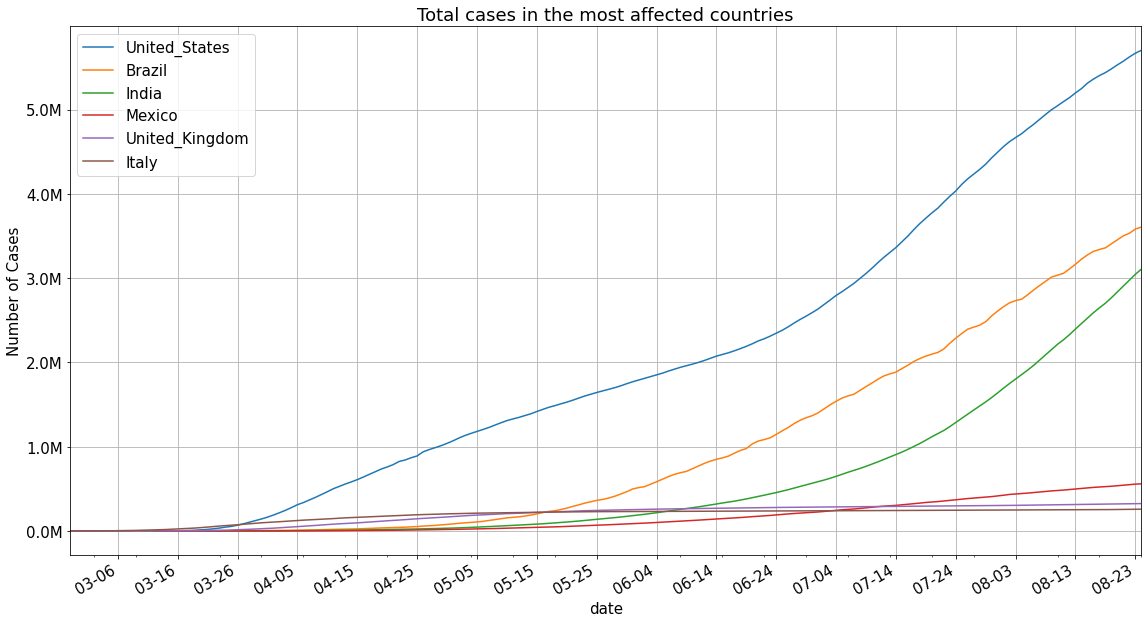

In [52]:
dfTotalCases.plot(x='date', y=dfCountry, figsize=(19.20,10.80))

plt.ylabel('Number of Cases')
plt.title('Total cases in the most affected countries')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
plt.gcf().autofmt_xdate()

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.1f}'.format(y/1000000) + 'M'))

plt.grid()
plt.show()

#### Log analysis - log<sub>b</sub><sup>x</sup>

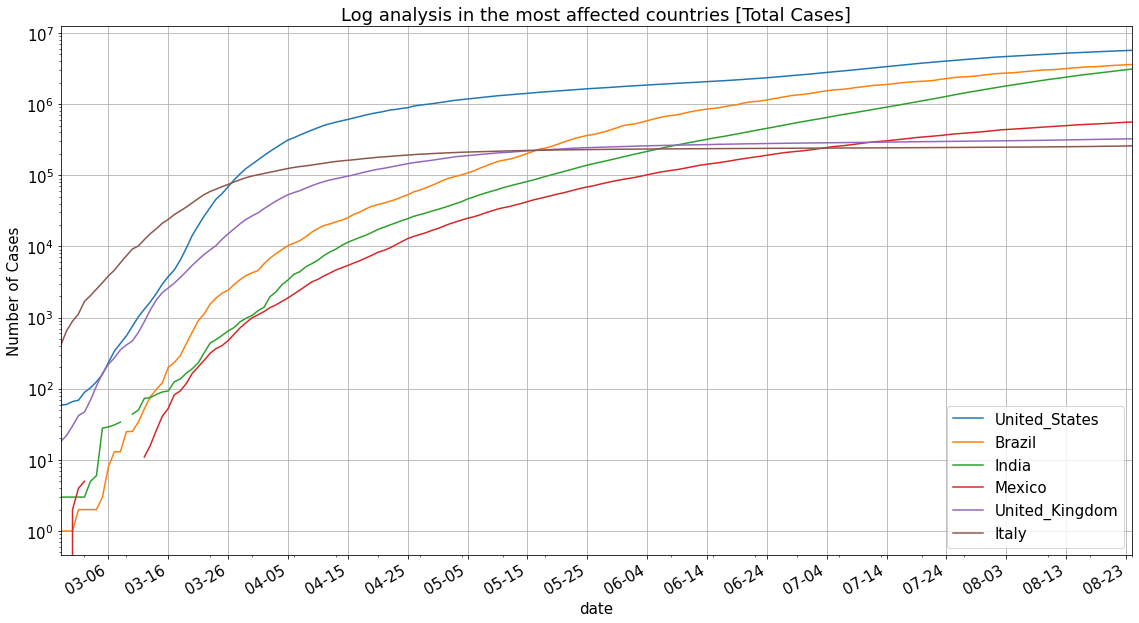

In [53]:
dfTotalCases.plot(x='date', y=dfCountry, logx=False, logy=True, figsize=(19.20,10.80))

plt.ylabel('Number of Cases')
plt.title('Log analysis in the most affected countries [Total Cases]')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gcf().autofmt_xdate()

plt.grid()
plt.show()

### <ins>Total Deaths</ins> in the most affected countries

In [54]:
dfTotalDeaths.sort_values(by=['date'], ascending=True)

,date,United_States,Brazil,India,Mexico,United_Kingdom,Italy
0,2020-02-27,0.0,0.0,0.0,0.0,0.0,12.0
1,2020-02-28,0.0,0.0,0.0,0.0,0.0,17.0
2,2020-02-29,0.0,0.0,0.0,0.0,0.0,21.0
3,2020-03-01,1.0,0.0,0.0,0.0,0.0,29.0
4,2020-03-02,2.0,0.0,0.0,0.0,0.0,35.0
...,...,...,...,...,...,...,...
175,2020-08-20,173177.0,111100.0,53866.0,58481.0,41397.0,35412.0
176,2020-08-21,174255.0,112304.0,54849.0,59106.0,41403.0,35418.0
177,2020-08-22,175406.0,113358.0,55794.0,59610.0,41405.0,35427.0
178,2020-08-23,176362.0,114250.0,56706.0,60254.0,41423.0,35430.0


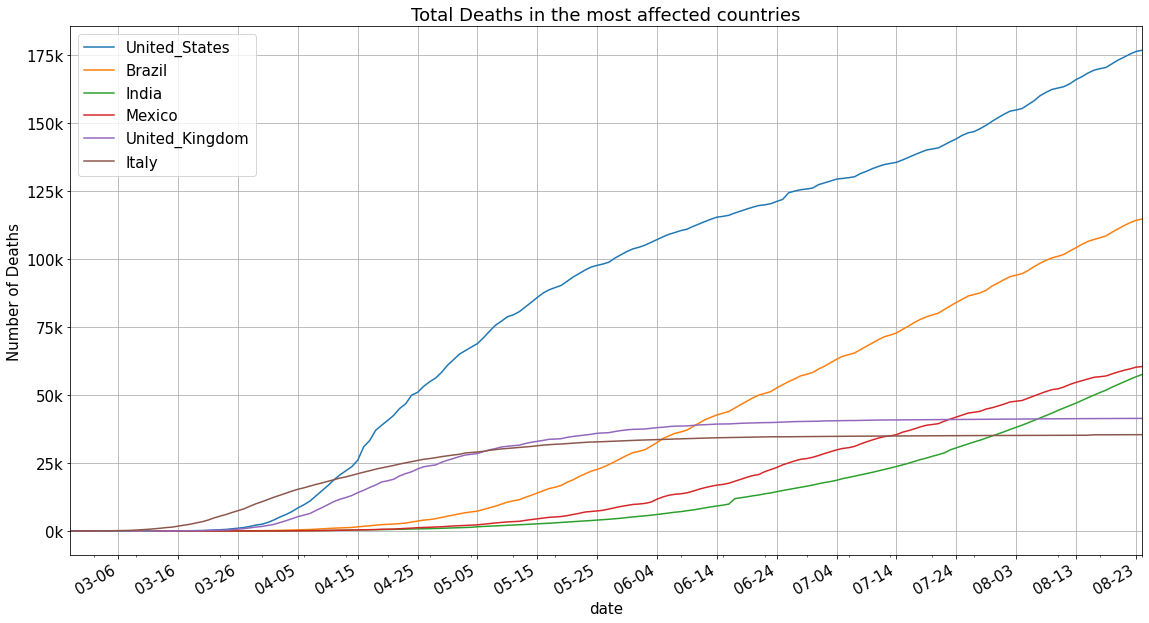

In [55]:
dfTotalDeaths.plot(x='date', y=dfCountry, figsize=(19.20,10.80))

plt.ylabel('Number of Deaths')
plt.title('Total Deaths in the most affected countries')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y/1000) + 'k'))

plt.gcf().autofmt_xdate()

plt.grid()
plt.show()

#### Log analysis - log<sub>b</sub><sup>x</sup>

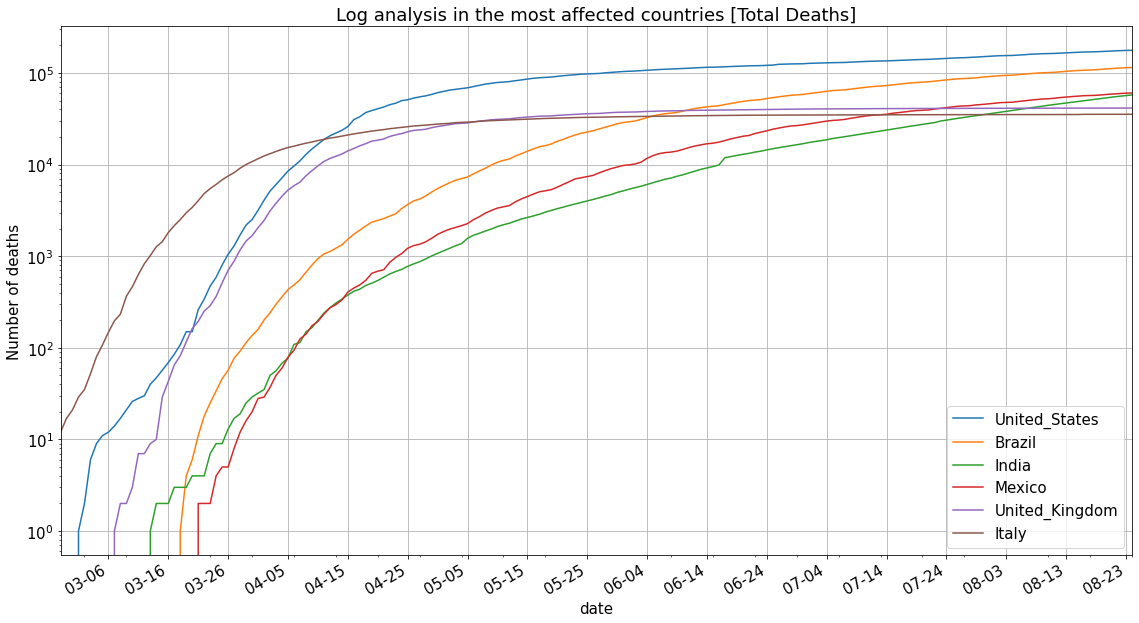

In [56]:
dfTotalDeaths.plot(x='date', y=dfCountry, logx=False, logy=True, figsize=(19.20,10.80))

plt.ylabel('Number of deaths')
plt.title('Log analysis in the most affected countries [Total Deaths]')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gcf().autofmt_xdate()

plt.grid()
plt.show()

### Total cases and deaths by country

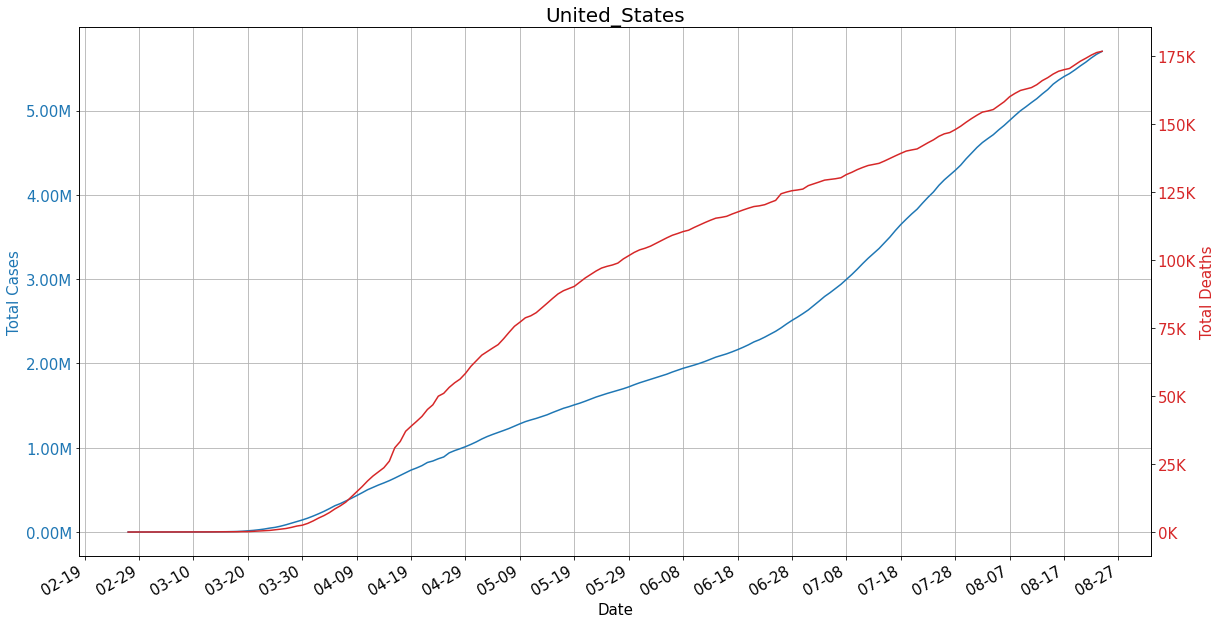

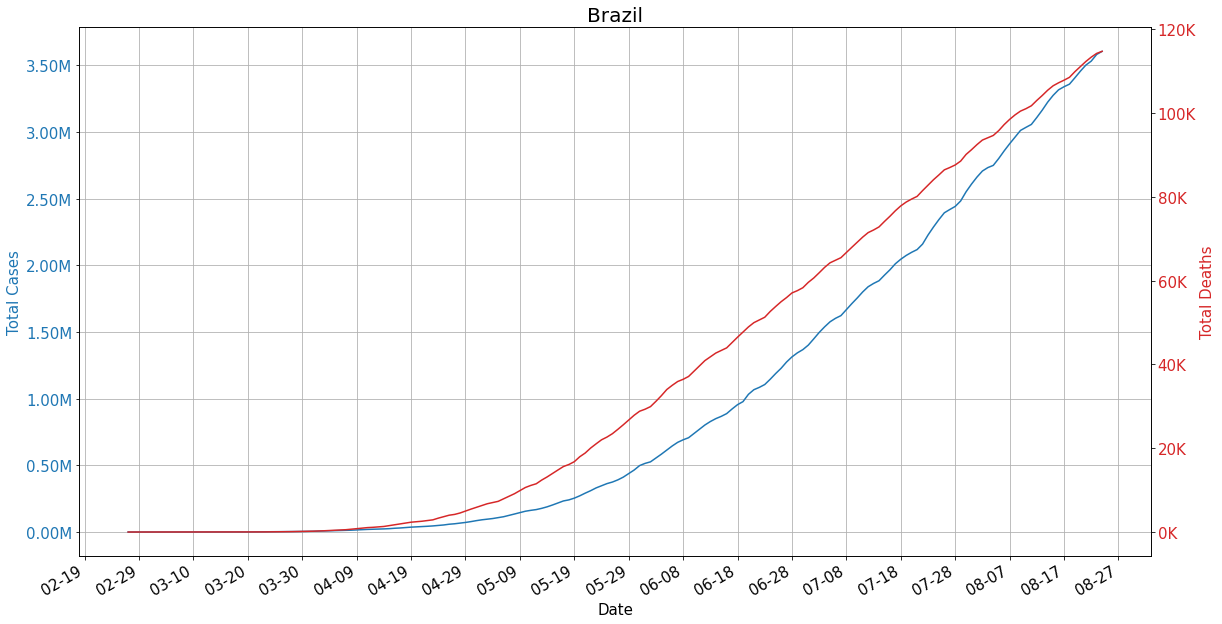

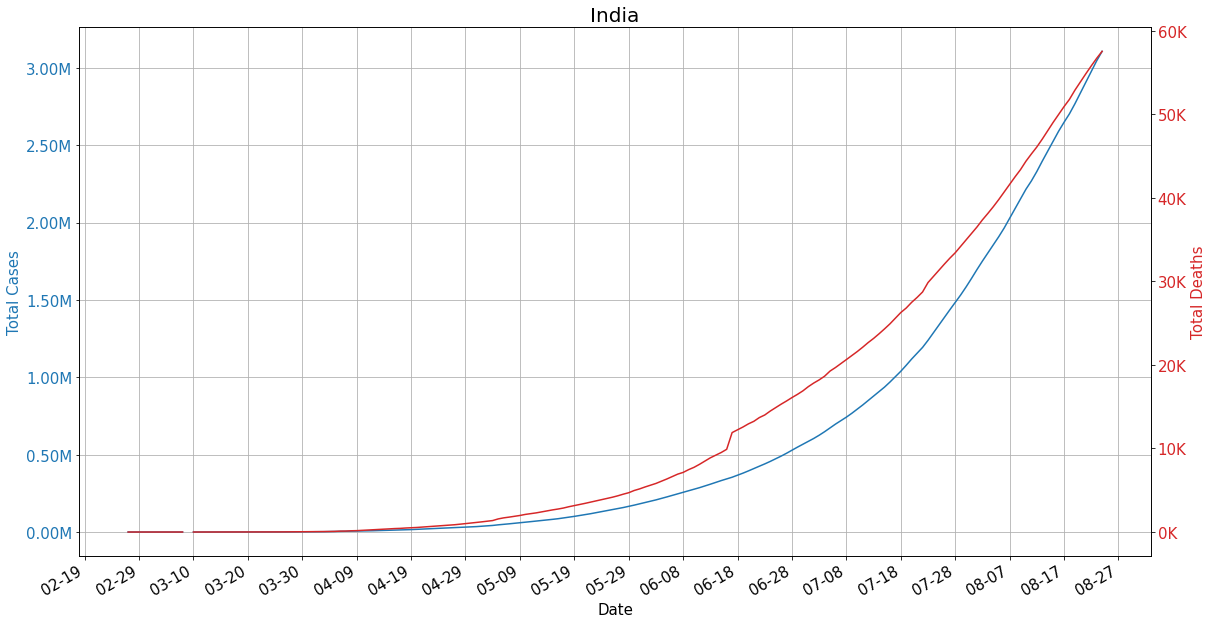

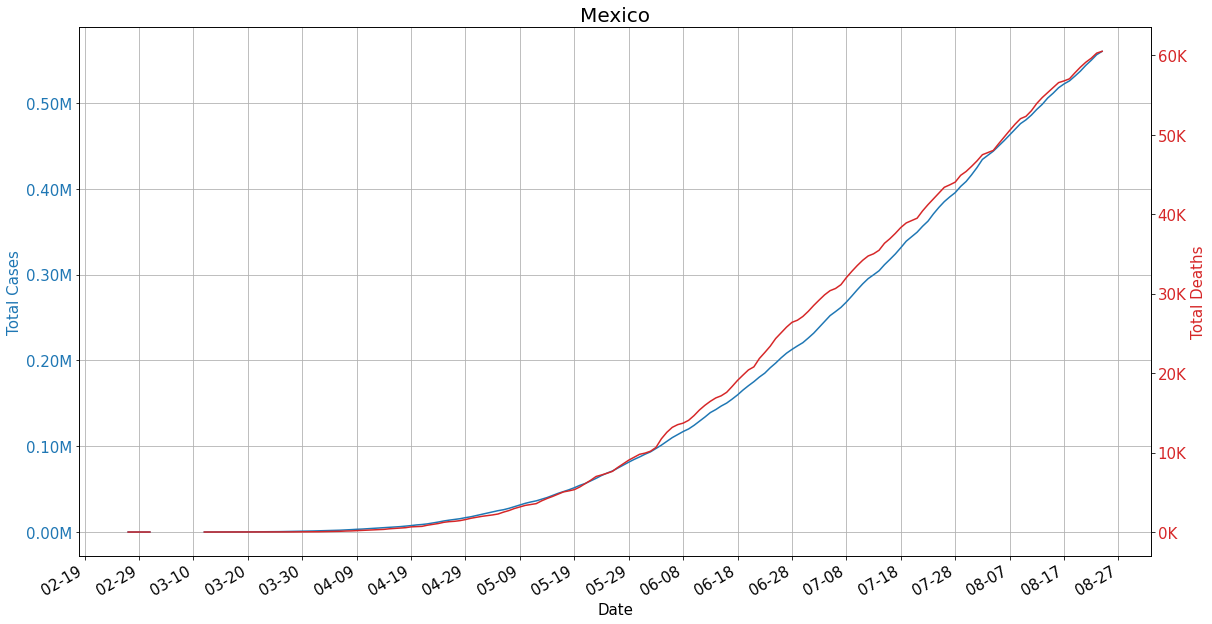

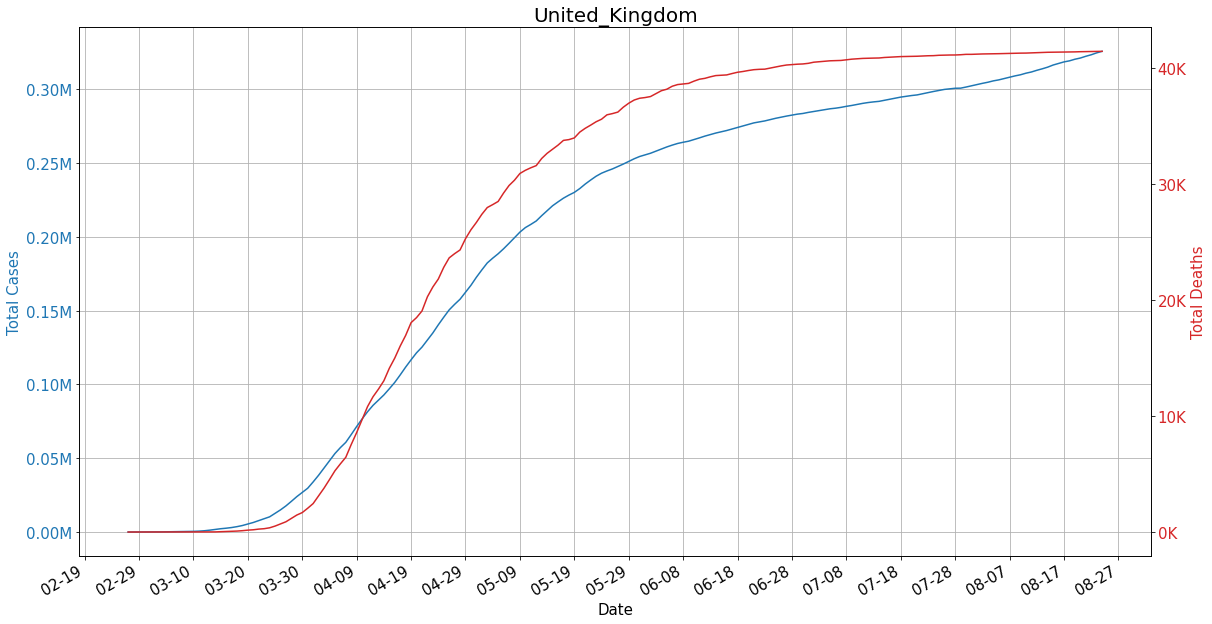

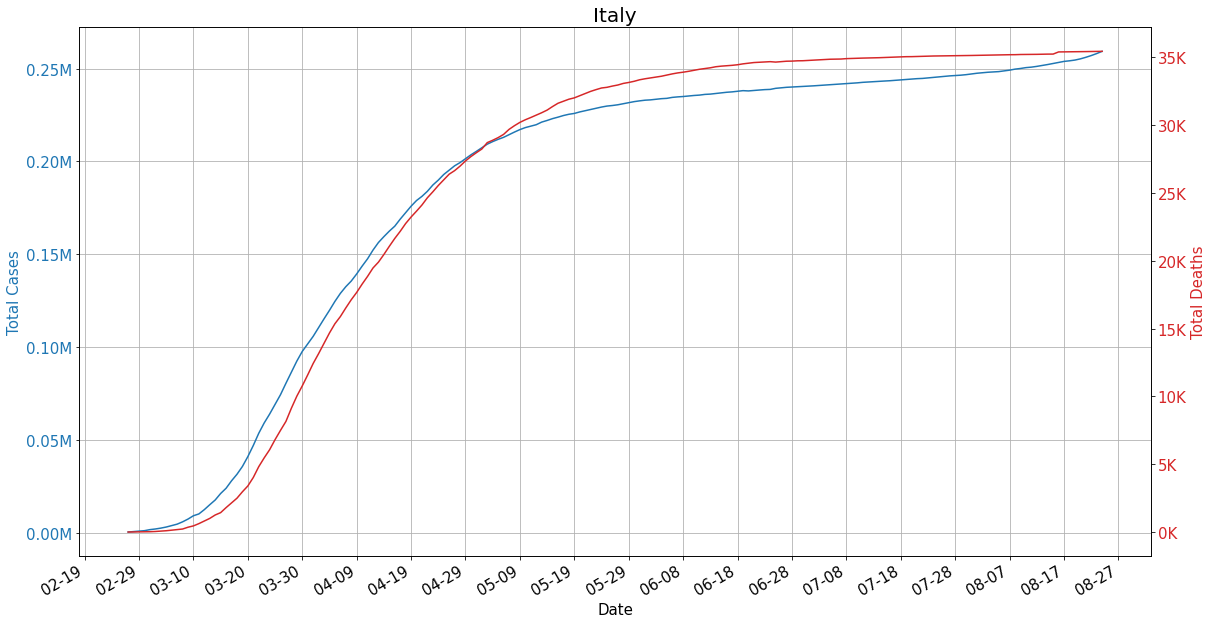

In [57]:
for index in range(1, len(dfCountry)+1,1):
    fig, ax1 = plt.subplots(figsize=(19.20,10.80))
    color = 'tab:blue'
    ax1.plot(dfTotalCases.date, dfTotalCases.iloc[:,index], color=color, label='Total Cases')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Total Cases', color=color)
    plt.title(dfCountry[index-1], fontsize=20)
    ax1.tick_params(axis='y', labelcolor=color)
    plt.ticklabel_format(style='plain', axis='y')
    
    plt.grid()
    
    ax2 = ax1.twinx()

    color = 'tab:red'
    ax2.plot(dfTotalDeaths.date, dfTotalDeaths.iloc[:,index], color=color, label = 'Total Deaths')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Total Deaths', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
    
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.2f}'.format(y/1000000) + 'M'))
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y/1000) + 'K'))

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    plt.gcf().autofmt_xdate()
    plt.show()

### <ins>Daily Cases</ins> in the most affected countries

In [58]:
dfNewCases.sort_values(by=['date'], ascending=True)

,date,United_States,Brazil,India,Mexico,United_Kingdom,Italy
0,2020-02-27,6.0,0.0,0.0,0.0,5.0,78.0
1,2020-02-28,1.0,0.0,0.0,0.0,4.0,250.0
2,2020-02-29,6.0,0.0,0.0,2.0,8.0,238.0
3,2020-03-01,3.0,1.0,0.0,2.0,12.0,240.0
4,2020-03-02,20.0,0.0,0.0,1.0,5.0,561.0
...,...,...,...,...,...,...,...
175,2020-08-20,47426.0,49298.0,69652.0,5792.0,812.0,642.0
176,2020-08-21,44005.0,45323.0,68898.0,6775.0,1182.0,840.0
177,2020-08-22,49880.0,30355.0,69878.0,5928.0,1033.0,947.0
178,2020-08-23,44378.0,50032.0,69239.0,6482.0,1288.0,1071.0


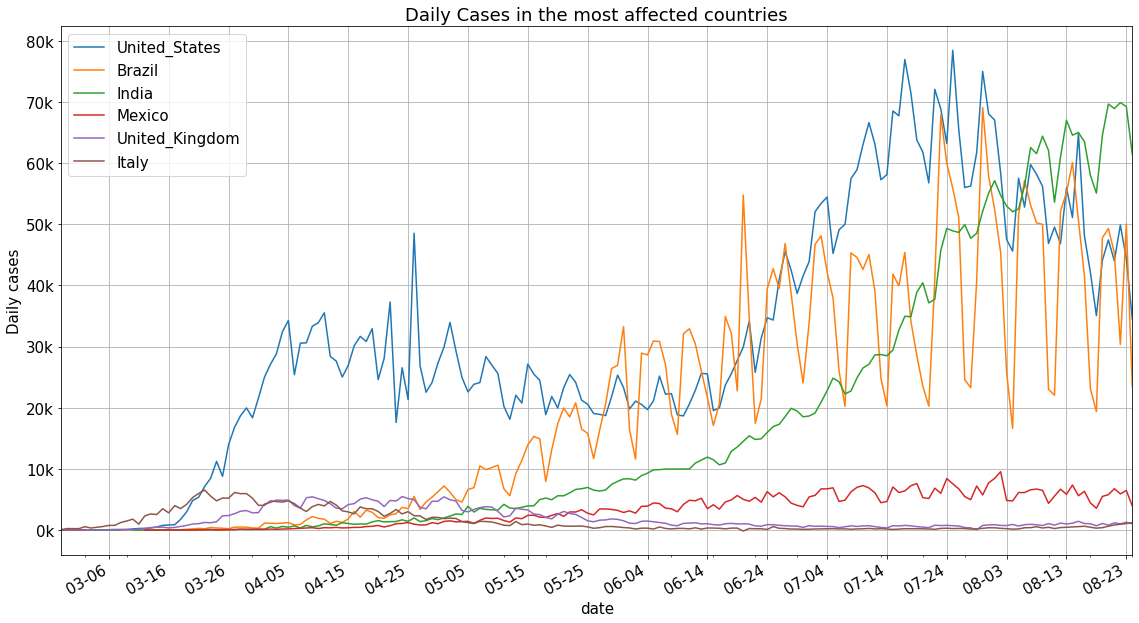

In [59]:
dfNewCases.plot(x='date', y=dfCountry, figsize=(19.20,10.80))

plt.ylabel('Daily cases')
plt.title('Daily Cases in the most affected countries')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y/1000) + 'k'))
plt.gcf().autofmt_xdate()

plt.grid()
plt.show()

### <ins>Daily Deaths</ins> in the most affected countries

In [60]:
dfNewDeaths.sort_values(by=['date'], ascending=True)

,date,United_States,Brazil,India,Mexico,United_Kingdom,Italy
0,2020-02-27,0.0,0.0,0.0,0.0,0.0,1.0
1,2020-02-28,0.0,0.0,0.0,0.0,0.0,5.0
2,2020-02-29,0.0,0.0,0.0,0.0,0.0,4.0
3,2020-03-01,1.0,0.0,0.0,0.0,0.0,8.0
4,2020-03-02,1.0,0.0,0.0,0.0,0.0,6.0
...,...,...,...,...,...,...,...
175,2020-08-20,1356.0,1212.0,977.0,707.0,16.0,7.0
176,2020-08-21,1078.0,1204.0,983.0,625.0,6.0,6.0
177,2020-08-22,1151.0,1054.0,945.0,504.0,2.0,9.0
178,2020-08-23,956.0,892.0,912.0,644.0,18.0,3.0


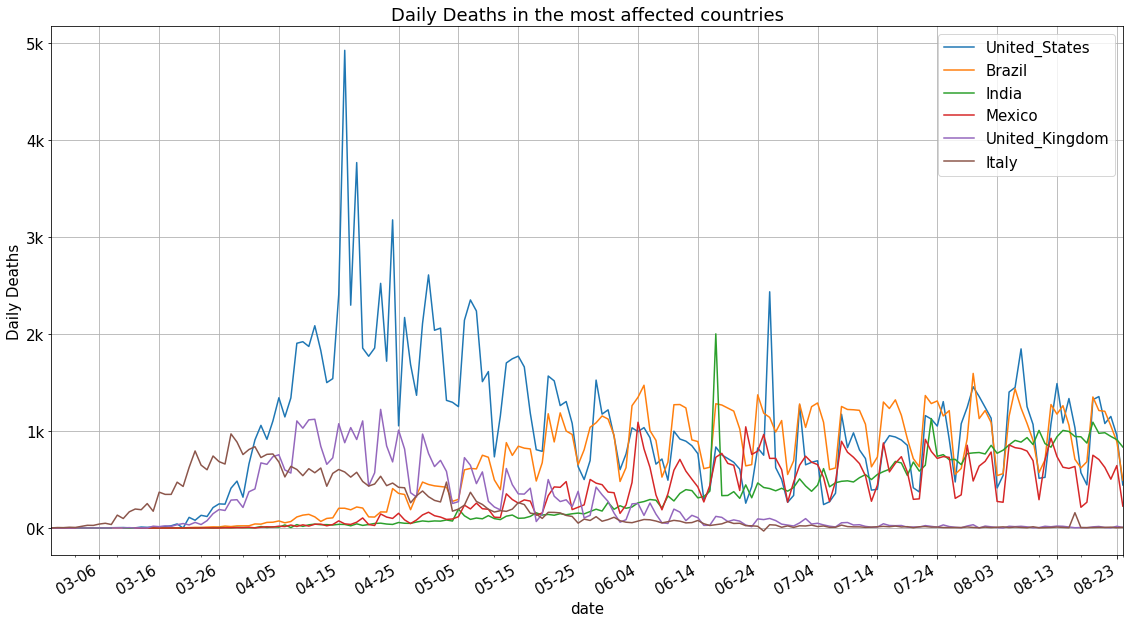

In [61]:
dfNewDeaths.plot(x='date', y=dfCountry, figsize=(19.20,10.80))

plt.ylabel('Daily Deaths')
plt.title('Daily Deaths in the most affected countries')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y/1000) + 'k'))
plt.gcf().autofmt_xdate()

plt.grid()
plt.show()

### Daily cases and deaths by country

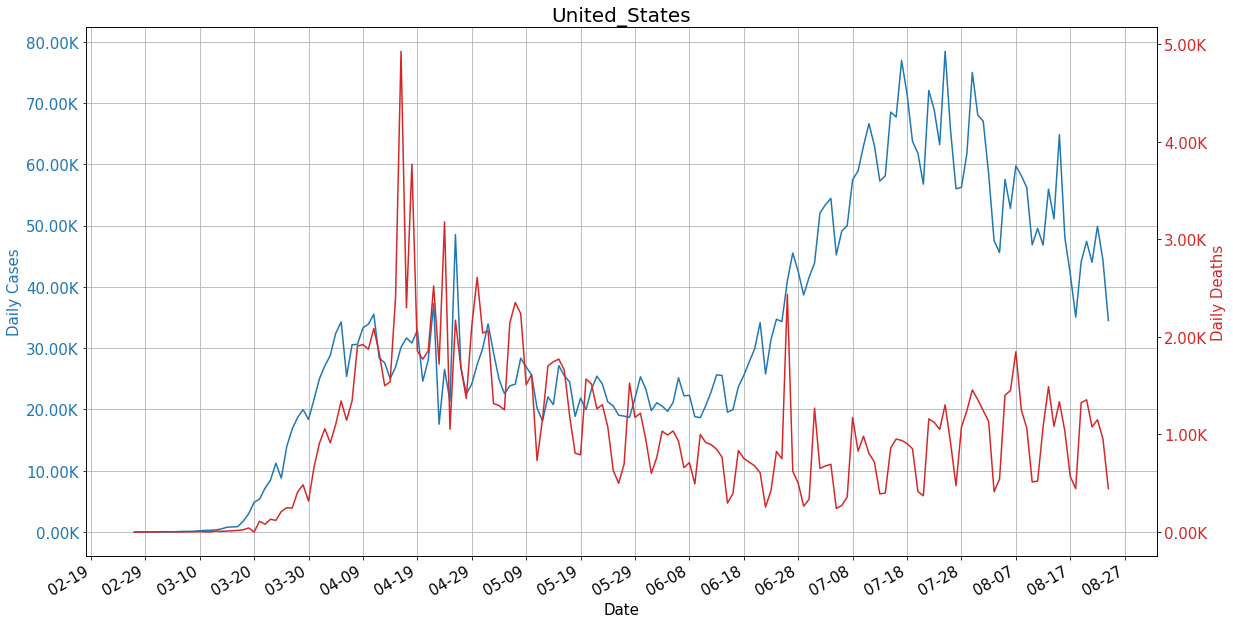

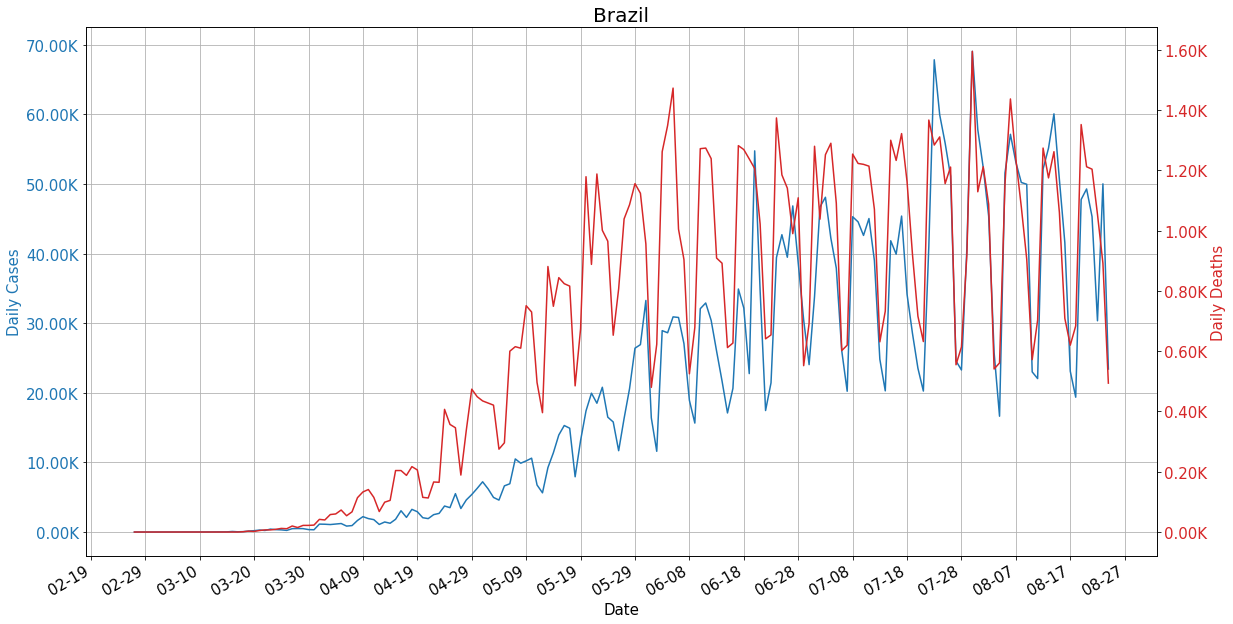

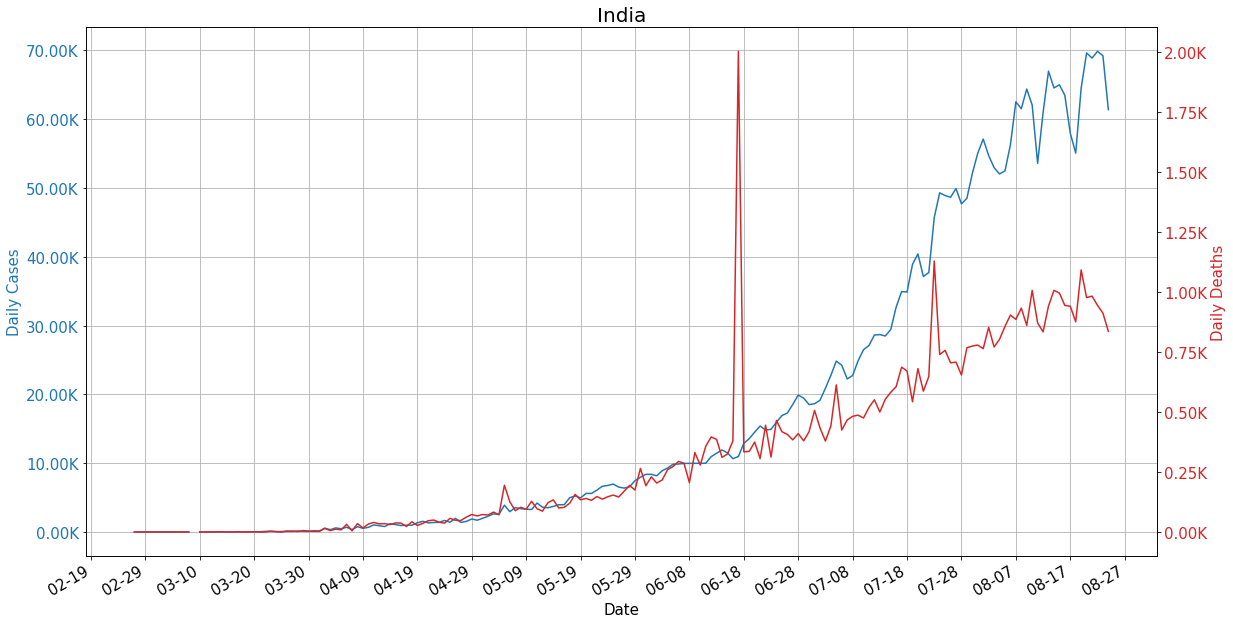

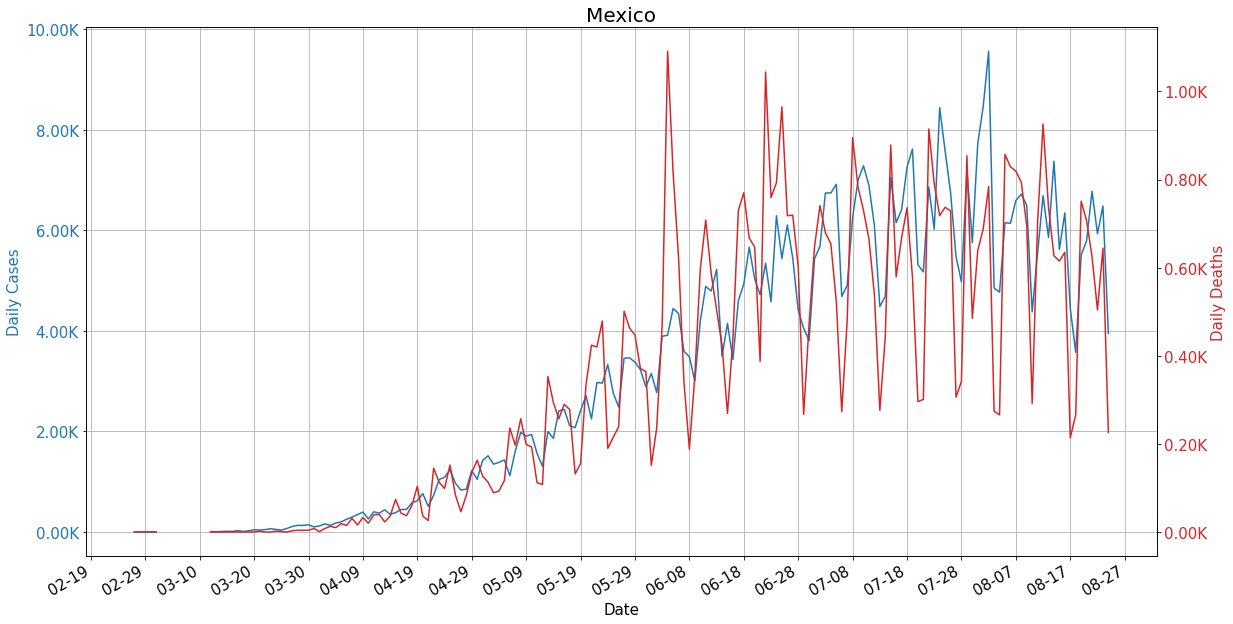

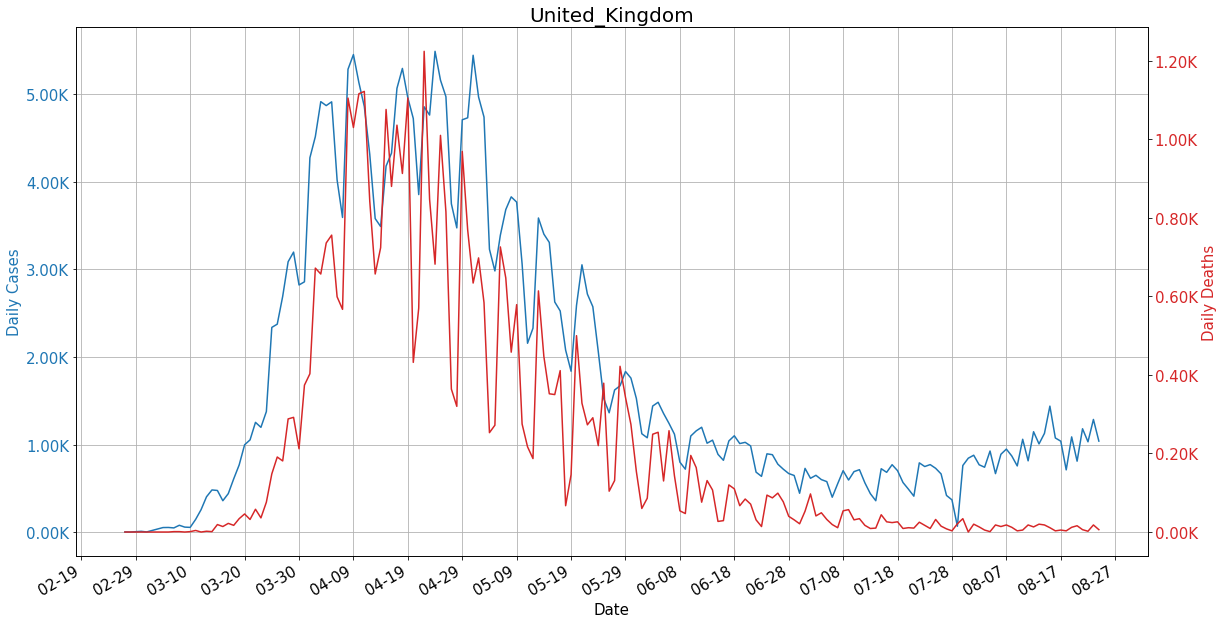

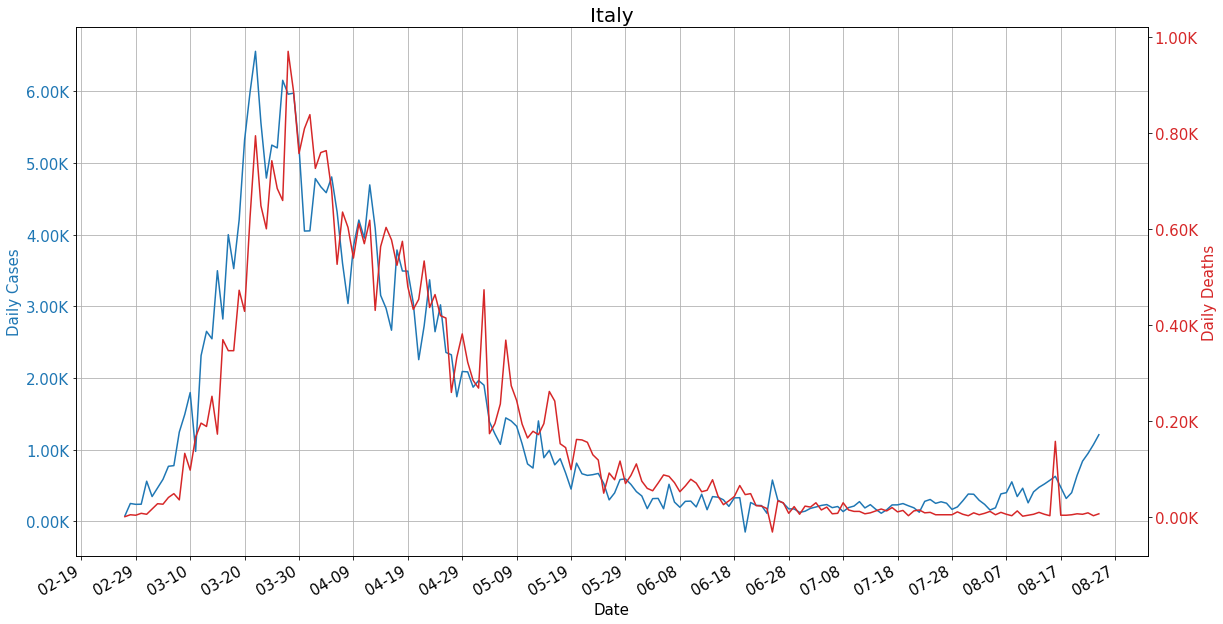

In [62]:
for index in range(1, len(dfCountry)+1,1):
    fig, ax1 = plt.subplots(figsize=(19.20,10.80))
    color = 'tab:blue'
    ax1.plot(dfNewCases.date, dfNewCases.iloc[:,index], color=color, label='Total Cases')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Daily Cases', color=color)
    plt.title(dfCountry[index-1], fontsize=20)
    ax1.tick_params(axis='y', labelcolor=color)
    plt.ticklabel_format(style='plain', axis='y')
    
    plt.grid()
    
    ax2 = ax1.twinx()

    color = 'tab:red'
    ax2.plot(dfNewDeaths.date, dfNewDeaths.iloc[:,index], color=color, label = 'Total Deaths')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Daily Deaths', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
    
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.2f}'.format(y/1000) + 'K'))
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.2f}'.format(y/1000) + 'K'))

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    plt.gcf().autofmt_xdate()
    plt.show()